In [22]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

## Lendo base de dados

In [23]:
db = fetch_lfw_people()

In [24]:
faces = db['data']

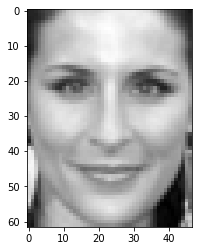

In [25]:
plt.imshow(faces[2000].reshape(62, 47), cmap='gray')

In [26]:
faces[0].shape

(2914,)

In [27]:
len(faces)

13233

In [28]:
type(faces)

numpy.ndarray

Tem um problema. As imagens sao em 62x47, que são dimensões bem ruins pq não dá pra comprimir em tamanhos muito distintos. São números primos/quase primos.

Solução por agora: tirar a primeira e ultima linha, e primeira e ultima coluna, transformando a imagem em 60x44, que é um número bem melhor pra comprimir para vários tamanhos diferentes.

In [8]:
faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[0:60, 0:44]

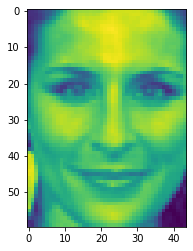

In [9]:
plt.imshow(faces_matrix[2000])

## Atenção: vou sobrescrever `faces`. Não sei se isso é uma boa prática.

In [10]:
del faces
faces = faces_matrix

In [29]:
# Normalizando imagens
faces = faces/255

In [30]:
# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray

In [31]:
newfaces = add_noise(0.05, faces)

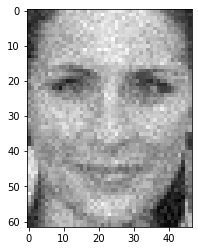

In [33]:
plt.imshow(newfaces[2000].reshape(62, 47), cmap='gray') # caso não tenha redimensionado

In [32]:
plt.imshow(newfaces[2000].reshape(60, 44), cmap='gray')

ValueError: cannot reshape array of size 2914 into shape (60,44)

No Keras tem esses tipos de layers:

* core layers

* convolutional layers

* pooling layers

* locally connected layers

* recurrent layers

* embedding layers

* merge layers

* advanced activations layers

* normalization layers

* noise layers

## Definindo DAE pequeno, só com core layers

In [34]:
# Definindo DAE
k = 30
shape = (60, 44)
shape = (62, 47)

In [35]:
inputs  = Input(shape = (np.prod(shape), )) # flattened image
enc_fc  = Dense(k, activation = 'relu') # encode to k data points
encoded = enc_fc(inputs)

In [36]:
dec_fc  = Dense(np.prod(shape), activation = 'sigmoid') # to original size
decoded = dec_fc(encoded)

In [37]:
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
autoencoder.fit(newfaces, faces, epochs=50, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
13233/13233 [==============================] - 2s 129us/step - loss: 0.6795
Epoch 2/50
13233/13233 [==============================] - 1s 74us/step - loss: 0.6732
Epoch 3/50
13233/13233 [==============================] - 1s 75us/step - loss: 0.6727
Epoch 4/50
13233/13233 [==============================] - 1s 70us/step - loss: 0.6722
Epoch 5/50
13233/13233 [==============================] - 1s 71us/step - loss: 0.6717
Epoch 6/50
13233/13233 [==============================] - 1s 67us/step - loss: 0.6713
Epoch 7/50
13233/13233 [==============================] - 1s 67us/step - loss: 0.6709
Epoch 8/50
13233/13233 [==============================] - 1s 71us/step - loss: 0.6705
Epoch 9/50
13233/13233 [==============================] - 1s 71us/step - loss: 0.6702
Epoch 10/50
13233/13233 [==============================] - 1s 75us/step - loss: 0.6698
Epoch 11/50
13233/13233 [==============================] - 1s 86us/step - loss: 0.6695
Epo

In [20]:
np.shape(faces)

(13233, 60, 44)

In [21]:
np.shape(newfaces)

(13233, 60, 44)

In [ ]:
pred = autoencoder.predict(faces)

In [ ]:
plt.imshow(pred[2004].reshape(62, 47), cmap='gray')

# SOCORROOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

## Fazendo DAE um pouco maior (ainda só core layers)

Activations possíveis: https://keras.io/activations/

In [72]:
k = 10
shape = (60, 44)

In [12]:
def make_core_dae():
    # encode
    inputs = Input(shape = (np.prod(shape), ))
    x  = Dense(50, activation = 'tanh')(inputs)
    x  = Dropout(0.5)(x)
    x  = Dense(k, activation = 'relu')(x)
    
    # decode
    x  = Dense(50, activation = 'tanh')(x)
    
    decoded  = Dense(np.prod(shape), activation = 'sigmoid')(x)
    
    # build autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [13]:
autoencoder2 = make_core_dae()

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
autoencoder2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2914)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                145750    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 2914)              148614    
Total params: 295,424
Trainable params: 295,424
Non-trainable params: 0
_____________________________________________________

In [25]:
autoencoder2.fit(newfaces, faces, epochs=50, batch_size=128)

Epoch 1/30
13233/13233 [==============================] - 2s 166us/step - loss: 0.6649
Epoch 2/30
13233/13233 [==============================] - 2s 161us/step - loss: 0.6647
Epoch 3/30
13233/13233 [==============================] - 2s 163us/step - loss: 0.6642
Epoch 4/30
13233/13233 [==============================] - 2s 165us/step - loss: 0.6638
Epoch 5/30
13233/13233 [==============================] - 2s 165us/step - loss: 0.6638
Epoch 6/30
13233/13233 [==============================] - 2s 166us/step - loss: 0.6633
Epoch 7/30
13233/13233 [==============================] - 2s 162us/step - loss: 0.6628
Epoch 8/30
13233/13233 [==============================] - 2s 164us/step - loss: 0.6627
Epoch 9/30
13233/13233 [==============================] - 2s 173us/step - loss: 0.6621
Epoch 10/30
13233/13233 [==============================] - 2s 158us/step - loss: 0.6624
Epoch 11/30
13233/13233 [==============================] - 2s 169us/step - loss: 0.6618
Epoch 12/30
13233/13233 [================

In [26]:
pred2 = autoencoder2.predict(faces)

In [86]:
plt.imshow(pred2[0].reshape(62, 47), cmap='gray')

NameError: name 'pred2' is not defined

## Convolutional autoencoder

In [75]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(60, 44, 1)) # input_4 (None, 60, 44, 1) 
    x = Conv2D( 16, 3, activation='relu', padding='same')(inputs) # conv2d_9 (None, 62, 47, 16)
    x = MaxPooling2D(padding='same')(x) # max_pooling2d_4 (None, 31, 24, 16)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_10 (None, 31, 24, 8)
    x = MaxPooling2D(padding='same')(x) # max_pooling2d_5 (None, 16, 12, 8)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_11 (None, 16, 12, 8)
    encoded = MaxPooling2D(padding='same')(x) # max_pooling2d_6 (None, 8, 6, 8)
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded) # conv2d_12 (None, 62, 47, 16)
    x = UpSampling2D()(x) # up_sampling2d_4 (None, 16, 12, 8)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) # conv2d_13 (None, 16, 12, 8)
    x = UpSampling2D()(x) # up_sampling2d_5 (None, 32, 24, 8)
    x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'! # conv2d_14 (None, 30, 22, 16)
    x = UpSampling2D()(x) # up_sampling2d_6 (None, 60, 44, 16)
    #decoded = Dense(1, activation = 'sigmoid')(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x) # conv2d_15 (None, 60, 44, 1)  
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [76]:
deep_autoencoder = make_convolutional_autoencoder()

In [77]:
deep_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 22, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 22, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 11, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 11, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 6, 8)           0   

In [11]:
# tem que fazer reshape pq os inputs e outputs, qdo passam pela conv2D, passam a ser tensores com 4 dimensões.

newfaces = newfaces.reshape(-1, 60, 44, 1)
faces = faces.reshape(-1, 60, 44, 1)

In [80]:
deep_autoencoder.fit(newfaces, faces, epochs=50, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
13233/13233 [==============================] - 8s 568us/step - loss: 0.6611
Epoch 2/50
13233/13233 [==============================] - 5s 367us/step - loss: 0.6420
Epoch 3/50
13233/13233 [==============================] - 5s 367us/step - loss: 0.6382
Epoch 4/50
13233/13233 [==============================] - 5s 367us/step - loss: 0.6365
Epoch 5/50
13233/13233 [==============================] - 5s 373us/step - loss: 0.6356
Epoch 6/50
13233/13233 [==============================] - 5s 384us/step - loss: 0.6349
Epoch 7/50
13233/13233 [==============================] - 5s 374us/step - loss: 0.6345
Epoch 8/50
13233/13233 [==============================] - 5s 362us/step - loss: 0.6342
Epoch 9/50
13233/13233 [==============================] - 5s 370us/step - loss: 0.6338
Epoch 10/50
13233/13233 [==============================] - 5s 367us/step - loss: 0.6337
Epoch 11/50
13233/13233 [==============================] - 5s 372us/step - loss: 

In [82]:
pred_deep = deep_autoencoder.predict(faces)

## Input

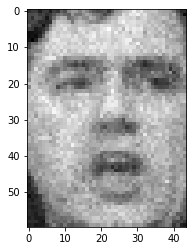

In [91]:
plt.imshow(newfaces[2004].reshape(60,44), cmap='gray')

## Output

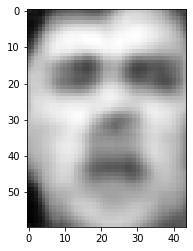

In [89]:
plt.imshow(pred_deep[2004].reshape(60, 44), cmap='gray')

## Imagem original

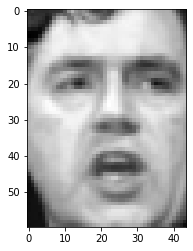

In [90]:
plt.imshow(faces[2004].reshape(60,44), cmap='gray')

### Rede pequena mas com layer convolucional - melhor até agora!

In [12]:
def make_small_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(60, 44, 1)) 
    x = Conv2D( 16, 3, activation='relu', padding='same')(inputs) 
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x) 
    encoded = MaxPooling2D(padding='same')(x)
    
    # decoding
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x) 
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [13]:
small_conv_autoencoder = make_small_convolutional_autoencoder()

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
small_conv_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 22, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________

In [15]:
small_conv_autoencoder.fit(newfaces, faces, epochs=50, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
13233/13233 [==============================] - 22s 2ms/step - loss: 0.6530
Epoch 2/50
13233/13233 [==============================] - 23s 2ms/step - loss: 0.6290
Epoch 3/50
13233/13233 [==============================] - 22s 2ms/step - loss: 0.6271
Epoch 4/50
13233/13233 [==============================] - 20s 2ms/step - loss: 0.6260
Epoch 5/50
13233/13233 [==============================] - 20s 1ms/step - loss: 0.6256
Epoch 6/50
13233/13233 [==============================] - 20s 2ms/step - loss: 0.6253
Epoch 7/50
13233/13233 [==============================] - 20s 2ms/step - loss: 0.6252
Epoch 8/50
13233/13233 [==============================] - 21s 2ms/step - loss: 0.6251
Epoch 9/50
13233/13233 [==============================] - 20s 2ms/step - loss: 0.6250
Epoch 10/50
13233/13233 [==============================] - 20s 1ms/step - loss: 0.6249
Epoch 11/50
13233/13233 [==============================] - 19s 1ms/step - loss: 0.6248
Epoc

In [16]:
pred_small = small_conv_autoencoder.predict(faces)

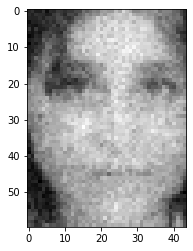

In [22]:
plt.imshow(newfaces[2003].reshape(60,44), cmap='gray')

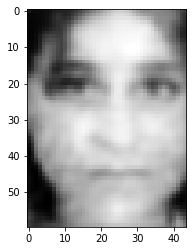

In [20]:
plt.imshow(pred_small[2003].reshape(60,44), cmap='gray')

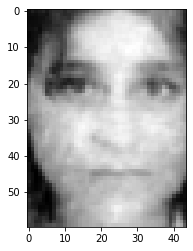

In [21]:
plt.imshow(faces[2003].reshape(60,44), cmap='gray')

In [51]:
def plota_pra_mim_pfv(pred, numero):
    figures, axes = plt.subplots(1,3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

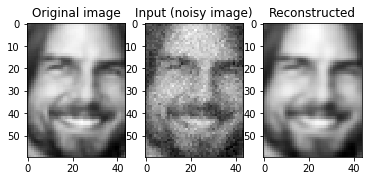

In [56]:
plota_pra_mim_pfv(pred_small, 9000)